In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

In [2]:
df = pd.read_csv("data/imagem3.txt", delim_whitespace=True, header=None)
df.columns = ['y', 'x', 'label', 'ndai', 'sd', 'corr', 'ra_df', 'ra_cf', 'ra_bf', 'ra_af', 'ra_an']

In [36]:
from typing import NamedTuple
from __future__ import annotations

class Coordinate(NamedTuple):
    x: int
    y: int

class Grid2DKernel(NamedTuple):
    dx: int
    dy: int

class Grid2D(NamedTuple):
    x0y0: Coordinate
    x1y0: Coordinate
    x0y1: Coordinate
    x1y1: Coordinate

    @staticmethod
    def get_polygon(start_coord: Coordinate, kernel: Grid2DKernel):
        x0, y0 = start_coord
        dx, dy = kernel

        return Grid2D(
            Coordinate(x0, y0),
            Coordinate(x0+dx-1, y0),
            Coordinate(x0, y0+dy-1),
            Coordinate(x0+dx-1, y0+dy-1),
        )
    
    @property
    def x_bound(self):
        return (self.x0y0.x, self.x1y0.x)
    
    @property
    def y_bound(self):
        return (self.x0y0.y, self.x1y1.y)
    
    def fully_contains(self, grid: Grid2D) -> bool:
        """Make sure the other grid is fully contained in this grid"""
        (my_x_lb, my_x_ub) = self.x_bound
        (other_x_lb, other_x_ub) = grid.x_bound

        (my_y_lb, my_y_ub) = self.y_bound
        (other_y_lb, other_y_ub) = grid.y_bound

        return (
            (my_x_lb <= other_x_lb)
            & (my_x_ub >= other_x_ub)
            & (my_y_lb <= other_y_lb)
            & (my_y_ub >= other_y_ub)
        )
    
    def neighbor_region(self, kernel: Grid2DKernel):
        """Get the neighborhood region of the kernel"""
        x0, y0 = self.x0y0
        dx, dy = kernel
        return Grid2D(
            Coordinate(x0-dx, y0-dy),
            Coordinate(x0+2*dx-1, y0-dy),
            Coordinate(x0-dx, y0+2*dy-1),
            Coordinate(x0+2*dx-1, y0+2*dy-1),
        )
    
    def move_forward(self, kernel: Grid2DKernel):
        x0, y0 = self.x0y0
        dx, _ = kernel
        return Grid2D.get_polygon(Coordinate(x0+dx, y0), kernel)


class SatelliteImage:
    def __init__(self, df: pd.DataFrame):
        self.df = df

        min_x, max_x = df.x.min(), df.x.max()
        min_y, max_y = df.y.min(), df.y.max()
        self.polygon = Grid2D.get_polygon(
            start_coord=Coordinate(min_x, min_y),
            kernel=Grid2DKernel(max_x-min_x+1, max_y-min_y+1)
        )
    


    def get_image_grid(self, grid: Grid2D):
        """Returns the image data given the grid polygon coordinates"""
        df = self.df

        x_lb, x_ub = grid.x_bound
        y_lb, y_ub = grid.y_bound
        
        x_bound = (df.x >= x_lb) & (df.x <= x_ub)
        y_bound = (df.y >= y_lb) & (df.y <= y_ub)

        return df[x_bound & y_bound]

In [37]:
kernel = Grid2DKernel(10, 10)
grid_polygon = Grid2D.get_polygon(Coordinate(70, 5), kernel)
image = SatelliteImage(df)
data_chunk = image.get_image_grid(grid_polygon)

<AxesSubplot:xlabel='x', ylabel='y'>

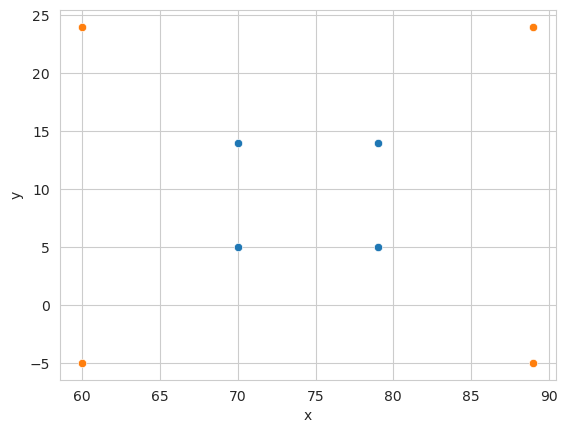

In [38]:
sns.scatterplot(data=pd.DataFrame(grid_polygon), x='x', y='y')
sns.scatterplot(data=pd.DataFrame(grid_polygon.neighbor_region(kernel)), x='x', y='y')